# LSTM model for observation operator

## Load in the required data

In [ ]:
import os
from pathlib import Path
pad = Path(os.getcwd())
if pad.name == "ml_observation_operator":
    pad_correct = pad.parent
    os.chdir(pad_correct)
%run "ml_observation_operator/data_load_in.py"

## Load in used packages

In [ ]:
# import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from numba import njit
import matplotlib.pyplot as plt
import hvplot
import hvplot.pandas
import hvplot.xarray
import itertools
import tensorflow as tf
import tensorflow_addons as tfa
import random as python_random
from tensorflow import keras
from keras import models, layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from typing import Tuple
from functions.plotting_functions import plot_tf_history
from functions.pre_processing import reshape_data, reshaped_to_train_test
from functions.ml_utils import general_tensorflow_model
#guanantee reproducability
SEED =1234
#os.environ['PYTHONHASHSEED'] = str(SEED)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
python_random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

exec_hyperopt_tuning = False

print(os.getcwd())
%load_ext autoreload 
%autoreload 2 

Check the distance between the days: give the number of days from the previous observation as an extra feature!! Will be used in LSTM trainig (cf obsidian notes)
Choice was made from the previous and not the next as in this way, when predicting $y_t$ with $x_t$ as last input, the distance from $t-1$ to $t$ is used an not from $t$ to $t+1$

This is performed in the `load_in.py` function

In [ ]:
ML_data_pad = Path("data/Zwalm_data/ML_data")
X_train_all = pd.read_pickle(ML_data_pad/"X_train_all.pkl")
X_test_all = pd.read_pickle(ML_data_pad/"X_test_all.pkl")
X_full_all = pd.read_pickle(ML_data_pad/"X_full_all.pkl")

X_train = pd.read_pickle(ML_data_pad/"X_train.pkl")
X_test = pd.read_pickle(ML_data_pad/"X_test.pkl")
X_full = pd.read_pickle(ML_data_pad/"X_full.pkl")
display(X_full.head())

X_train_small = pd.read_pickle(ML_data_pad/"X_train_small.pkl")
X_test_small = pd.read_pickle(ML_data_pad/"X_test_small.pkl")
X_full_small = pd.read_pickle(ML_data_pad/"X_full_small.pkl")
display(X_full_small.head())

y_train = pd.read_pickle(ML_data_pad/"y_train.pkl")
y_test = pd.read_pickle(ML_data_pad/"y_test.pkl")
y_full = pd.read_pickle(ML_data_pad/"y_full.pkl")

Cstar = pd.read_pickle(ML_data_pad/"Cstar.pkl")
display(Cstar.head())

In [ ]:
s1_xr_g0 = xr.open_dataset('data/g0_OpenEO/g0_zwalm_landuse.nc')
display(s1_xr_g0)
# s1_xr_g0['VV_db'] = 10*np.log10(s1_xr_g0['VV'])
# s1_xr_g0['VV_db'].hvplot.image('x','y', geo = True, crs = 32631, 
#                             tiles = 'OSM', cmap = 'bwr', frame_width = 320,
#                             rasterize = True)

Not really regular timeseries...

https://stats.stackexchange.com/questions/312609/rnn-for-irregular-time-intervals

Full set of possible features: Forest, Pasture, Agriculture and a combination of pasture and agriculture

Normalise the features beforehand (but keep delta_t for the RNN structure)

In [ ]:
scaler = StandardScaler()
scaler.fit(y_train.values.reshape(-1, 1))
y_train_norm = scaler.transform(y_train.values.reshape(-1,1))
y_test_norm = scaler.transform(y_test.values.reshape(-1,1))
y_full_norm = scaler.transform(y_full.values.reshape(-1,1))

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_norm = X_scaler.transform(X_train)
X_test_norm = X_scaler.transform(X_test)
X_full_norm = X_scaler.transform(X_full)

X_scaler_small = StandardScaler()
X_scaler_small.fit(X_train_small)
X_full_small_norm = X_scaler_small.transform(X_full_small)

Always working with the normalized data!

# Reshape the data

In [ ]:
print('train size: ' + str(y_train_norm.shape))
print('test size: ' + str(y_test_norm.shape))
print('full size: ' + str(y_full_norm.shape))

Experiment: drop the sinusoidal data again

In [ ]:
# X_full = X_full.drop(['year_sin','year_cos'],axis = 1)

Can only be applied on the full dataset!

In [ ]:
seq_length = 60
X_lstm_full, y_lstm_full, t_lstm_full = reshape_data(
    X_full_norm, y_full_norm,
    X_full.index, seq_length
)
n_train =  X_train.shape[0]
print('number of original trainig samples: ' + str(n_train))
X_lstm_full.shape

In [ ]:
print(y_train_norm[seq_length-1])
print(y_lstm_full[0])
#check

In [ ]:
print(X_full_norm[seq_length-1])
print(X_lstm_full[0,-1,:])
#check

In [ ]:
(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm,
  t_train_lstm, t_test_lstm) = reshaped_to_train_test(
    X_lstm_full, y_lstm_full, t_lstm_full, seq_length, n_train, output_dim = 3
)

In [ ]:
print(X_train_norm[seq_length-1,:])
print(X_train_lstm[0,-1,:]) #last entry of first training window

In [ ]:
print(X_test_norm[0,:])
print(X_test_lstm[0,-1,:]) #last entry of first test window 

In [ ]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)

So logical that you reduce from 579 to 520 training samples as yo can only start predicting form day 1!

## Initial LSTM model

https://github.com/kratzert/pangeo_lstm_example/blob/master/LSTM_for_rainfall_runoff_modelling.ipynb also applies normalisation!

Main idea visualised below from the paper of Kratzert (adapted to 1 recurrent layer)

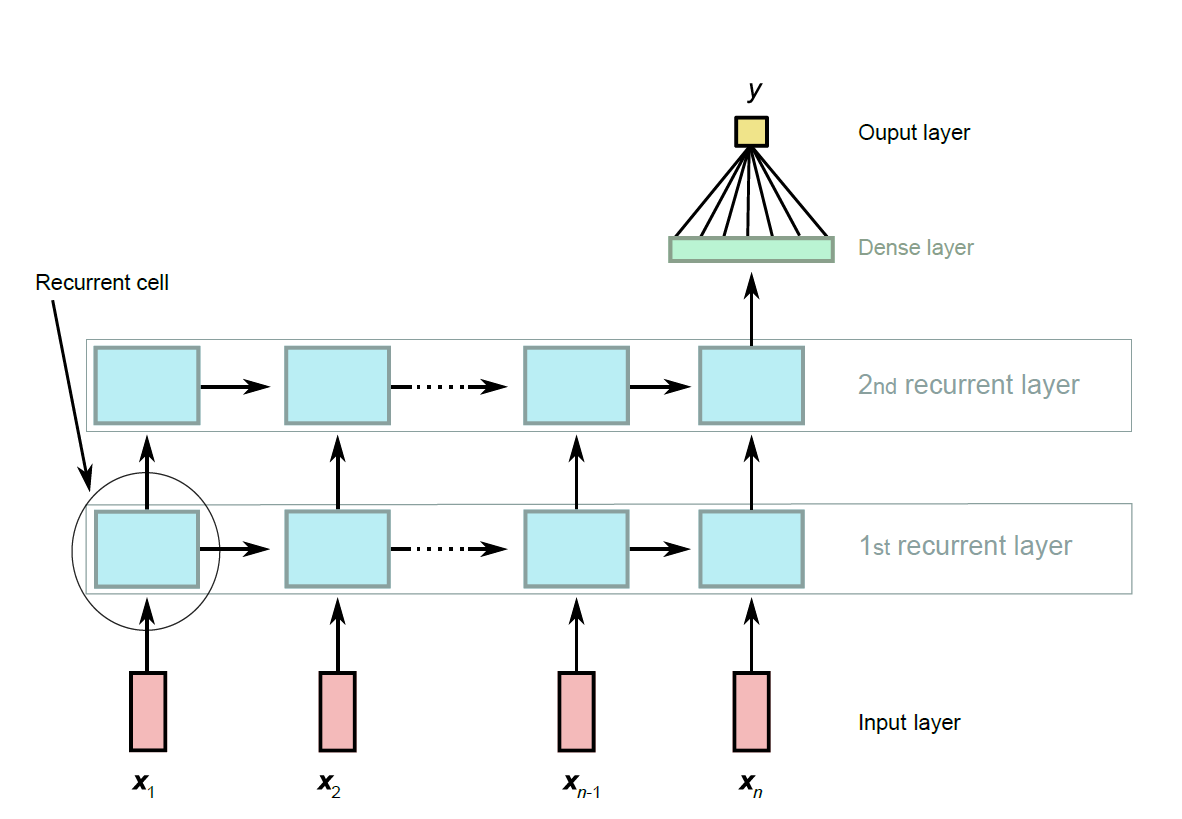

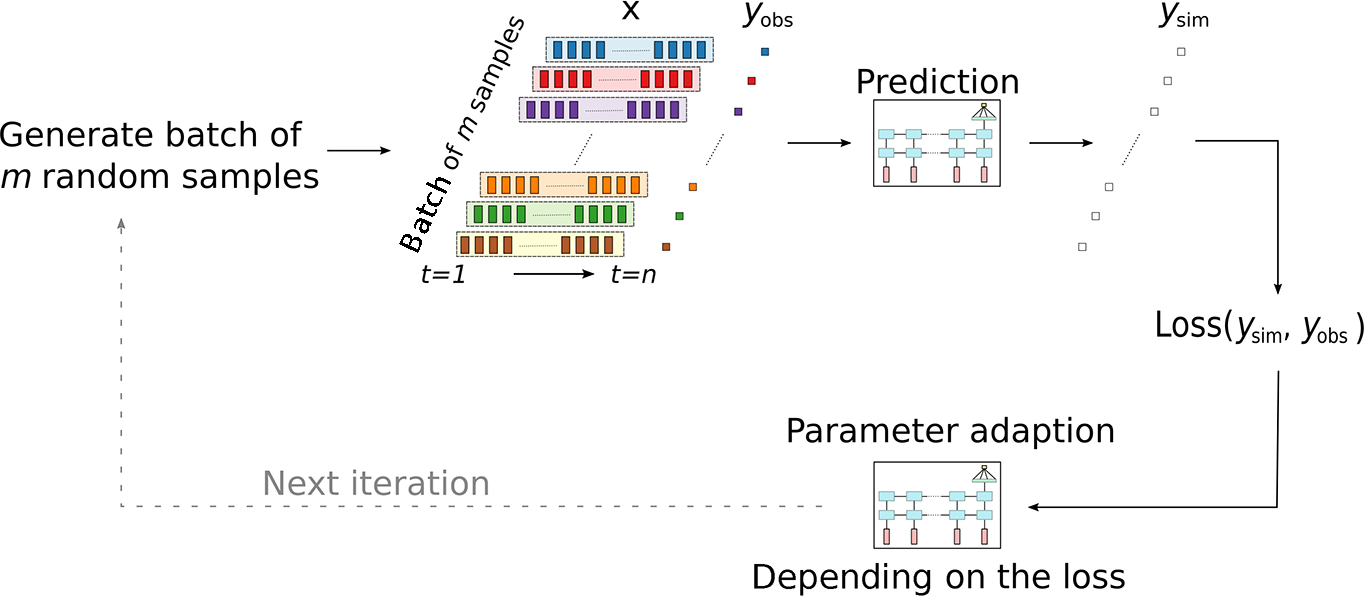

In [ ]:
# inputs = keras.layers.Input(shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]))
# lstm_out = keras.layers.LSTM(5)(inputs)
# outputs = keras.layers.Dense(1)(lstm_out)
n_hidden_units = 10
dropout_rate = 0
n_features = X_train.shape[1]
lstm_model = models.Sequential(
    [
    layers.Input(shape = (seq_length, n_features)),
    layers.LSTM(n_hidden_units, recurrent_dropout=dropout_rate),
    #keras.layers.Dropout(dropout_rate, seed = SEED),
    layers.Dense(1, activation = 'linear')
    ]
)
# lstm_model = keras.Model(inputs = inputs, outputs = outputs)
lstm_model.summary()

In [ ]:
(r2_train, r2_test, y_train_hat, y_test_hat, model, fig, ax,
  best_epoch) = general_tensorflow_model(lstm_model,
     X_train.values, X_test.values, y_train.values, y_test.values,
     X_train.index, X_test.index, Cstar, lstm = True, seq_length = seq_length,
     epochs = 100
  )

In [ ]:
best_epoch

In [ ]:
lstm_model.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = tfa.metrics.RSquare()
)
epochs = 20
val_split = 0.2

In [ ]:
scaler.inverse_transform(y_train_lstm[0].reshape(-1,1))

In [ ]:
y_full[59]

Add early stopping callback

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    batch_size = 32, epochs = epochs, validation_split = val_split, shuffle = False
    #callbacks = callback
)

In [ ]:
fig, ax = plot_tf_history(history, "r_square")

In [ ]:
val_loss = history.history['val_loss']
min_loss = np.min(val_loss)
best_epoch = np.argwhere(val_loss == min_loss)
print(val_loss[int(best_epoch)])
print(min_loss)

In [ ]:
y_train_hat = lstm_model.predict(X_train_lstm)
y_test_hat = lstm_model.predict(X_test_lstm)
y_full_hat = lstm_model.predict(X_lstm_full)

In [ ]:
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(t_train_lstm, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(t_test_lstm, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
#plt.plot(features.index[seq_length-1:], scaler.inverse_transform(y_full_hat), label = 'Full', alpha = 0.7, linestyle = '--')
# plt.plot(X_train.index, y_train_hat, label = 'Train', alpha = 0.7)
# plt.plot(X_test.index, y_test_hat, label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('LSTM: full dataset 10 hidden states')

In [ ]:
r2_train = r2_score(
    scaler.inverse_transform(y_train_lstm), 
    scaler.inverse_transform(y_train_hat)
)
r2_test = r2_score(
    scaler.inverse_transform(y_test_lstm),  
    scaler.inverse_transform(y_test_hat)
)
# r2_train = r2_score(y_train, y_train_hat)
# r2_test = r2_score(y_test, y_test_hat)
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

In [ ]:
r2_score(
    y_train_lstm, y_train_hat
)

 ### Without time and forest feature

In [ ]:
X_temp = pd.DataFrame(X_full_norm, columns = X_full.columns)
X_temp

In [ ]:
nr_epochs = 15
X_temp = pd.DataFrame(X_full_norm, columns = X_full.columns)
X_temp = X_temp.drop(['year_sin','year_cos'],axis = 1)
X_temp = X_temp.loc[:,~X_temp.columns.str.endswith('Forest')]
X_window, y_window, t_window = reshape_data(
    X_temp.values,y_full_norm,
    X_full.index.values, seq_length
)
(X_window_train, X_window_test, y_window_train, y_window_test, 
t_window_train, t_window_test) = reshaped_to_train_test(
    X_window, y_window, t_window, seq_length, n_train, output_dim = 3
)
lstm_model = models.Sequential(
    [
    layers.Input(shape = (X_window_train.shape[1], X_window_train.shape[2])),
    layers.LSTM(n_hidden_units),
    layers.Dropout(0.5),
    layers.Dense(1, activation = "linear"),

    ]
)
lstm_model.summary()
lstm_model.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = tfa.metrics.RSquare()
)
history = lstm_model.fit(
    X_window_train, y_window_train,
    batch_size = 32, epochs = nr_epochs, validation_split = 0.2
)

In [ ]:
fig, ax = plot_tf_history(history, "r_square")

In [ ]:
y_train_hat = lstm_model.predict(X_window_train)
y_test_hat = lstm_model.predict(X_window_test)

In [ ]:
fig,ax = plt.subplots()
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(t_train_lstm, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(t_test_lstm, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
#plt.plot(features.index[seq_length-1:], scaler.inverse_transform(y_full_hat), label = 'Full', alpha = 0.7, linestyle = '--')
# plt.plot(X_train.index, y_train_hat, label = 'Train', alpha = 0.7)
# plt.plot(X_test.index, y_test_hat, label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('LSTM')

In [ ]:
r2_train = r2_score(
    scaler.inverse_transform(y_train_lstm), 
    scaler.inverse_transform(y_train_hat)
)
r2_test = r2_score(
    scaler.inverse_transform(y_test_lstm),  
    scaler.inverse_transform(y_test_hat)
)
# r2_train = r2_score(y_train, y_train_hat)
# r2_test = r2_score(y_test, y_test_hat)
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

### Model of Kratzert 2018

reduce numer of hidden units from 20 to 10 since more input features in this case! Use the small dataset to prevent overfitting issues

In [ ]:
nr_epochs = 40 #15 seems reasonable after first trials (including time features)
#40 excluding time features
seq_length = 60
n_hidden_units = 20
X_window, y_window, t_window = reshape_data(
    X_full_norm,y_full_norm,
    X_full.index.values, seq_length
)
(X_window_train, X_window_test, y_window_train, y_window_test, 
t_window_train, t_window_test) = reshaped_to_train_test(
    X_window, y_window, t_window, seq_length, n_train, output_dim = 3
)
print(X_window.shape)

https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network on why return_sequences = True in first layer

In [ ]:
X_window_train.shape[2]

In [ ]:
kratzert_lstm = models.Sequential([
    layers.Input((X_window_train.shape[1], X_window_train.shape[2])),
    layers.LSTM(units = n_hidden_units, name = 'lstm_1', return_sequences = True),
    layers.Dropout(rate =0.1),
    layers.LSTM(units = n_hidden_units, name = 'lstm_2'),
    layers.Dropout(rate =0.1),
    layers.Dense(units =1, activation = 'linear')
])
kratzert_lstm.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = tfa.metrics.RSquare()
)
kratzert_lstm.summary()

In [ ]:
history = kratzert_lstm.fit(
    X_window_train, y_window_train,
    batch_size = 32, epochs = nr_epochs, validation_split = 0.2
)

In [ ]:
plot_tf_history(history, 'r_square')

In [ ]:
y_train_hat = kratzert_lstm.predict(X_window_train)
y_test_hat = kratzert_lstm.predict(X_window_test)
fig,ax = plt.subplots()
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(t_window_train, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(t_window_test, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.set_title('LSTM')
r2_train = r2_score(
    scaler.inverse_transform(y_train_lstm), 
    scaler.inverse_transform(y_train_hat)
)
r2_test = r2_score(
    scaler.inverse_transform(y_test_lstm),  
    scaler.inverse_transform(y_test_hat)
)
# r2_train = r2_score(y_train, y_train_hat)
# r2_test = r2_score(y_test, y_test_hat)
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

This model structure seems highly overfitted

# Hyperparameter tuning

## Grid Search on full dataset OLD

Things to experiment with in hyperarameter tuning:
- include sin and cos feature or not
- include forest dat or not
- vary the size of the hidden unit: 4,8,12,16
    - important
- vary the length of the input sequence: 10,20,30,40,50,60
    - important hyperparameter
- vary the learning rate: 1e-2, 1e-3, 1e-4
    - preliminary experiments seems to indicate that default learning rate of 1e-3 works best
- vary the dropout rate: 0, 0.1, 0.2, 0.3 and 0.4 
    - for simplicity: just choose 0.2 in this case
By not including all the options, (focusing on hidden units and input sequence length), the number of optoins to try is vastly reduced! 

Train each one for 100 epochs and retrieve the epoch with the best validation score (and this epochs number)

Problem with approach below: the length of the training sequence changes, and so the test data is not always of the same lenght in this approach

In [ ]:
#a model object that can be easily trained within a loop

https://arxiv.org/pdf/1603.05118v2.pdf on recurrent dropout

In [ ]:
nr_folds = 4 #for cross validation
nr_epochs = 100
n_train = X_train.shape[0]
range_forest = [True, False]
range_time = [True, False]
range_hidden_unit = np.arange(4,18,4)
range_input_seq = np.arange(10,70,10)
range_learning_rate = [1e-3]#np.logspace(-2,-4,4)
range_dropout_rate = [0,0.2]#np.arange(0,0.5,0.1) #compare no to little dropout. recurrent dropout used! 
nr_options = len(range_time)*len(range_forest)*len(
    range_input_seq)*len(range_learning_rate)*len(
    range_hidden_unit)*len(range_dropout_rate)
print(f"Total Number of combinations {nr_options}") 
col_names = ['seq_length','forest_bool','time_bool','hidden_units','learning_rate',
             'drop_out_rate','RMSE_val_mean','RMSE_val_sd','best_epoch']
pd_hyperparam = pd.DataFrame(columns=col_names, index = range(0,nr_options))
iter = 0
if exec_hyperopt_tuning:
    for seq_length in range_input_seq:
        for forest_bool in range_forest:
            for time_bool in range_time:
                X_temp = X_full.copy()
                if not time_bool:
                    X_temp = X_temp.drop(['year_sin','year_cos'],axis = 1)
                if not forest_bool:
                    X_temp = X_temp.loc[:,~X_temp.columns.str.endswith('Forest')]
                X_window, y_window, t_window = reshape_data(
                    X_temp.values,y_full_norm,
                    X_temp.index.values, seq_length
                )
                (X_window_train, X_window_test, y_window_train, y_window_test, 
                t_window_train, t_window_test) = reshaped_to_train_test(
                    X_window, y_window, t_window, seq_length, n_train, output_dim = 3
                )
                for learning_rate in range_learning_rate:
                    for hidden_units in range_hidden_unit:
                        for dropout_rate in range_dropout_rate:
                            kf = KFold(nr_folds, shuffle = False)
                            RMSE_val_list = []
                            best_epoch_list = []
                            for i, (train_index, test_index) in enumerate(kf.split(X_window_train)):  
                            #define the LSTM model
                                lstm_model = models.Sequential(
                                    [
                                    layers.Input(shape = (X_window_train.shape[1], X_window_train.shape[2])),
                                    layers.LSTM(hidden_units),
                                    layers.Dense(1, activation ='linear')
                                    ]
                                )
                                lstm_model.compile(
                                    loss = keras.losses.MeanSquaredError(),
                                    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
                                )
                                val_data =(X_window_train[test_index],y_window_train[test_index])
                                history = lstm_model.fit(
                                    X_window_train[train_index], y_window_train[train_index],
                                    batch_size = 32, epochs = nr_epochs, validation_data = val_data,
                                    verbose = 0
                                )
                                val_loss = history.history['val_loss']
                                min_loss = np.min(val_loss)
                                best_epoch = np.argwhere(val_loss == min_loss)
                                RMSE_val_list.append(min_loss)
                                best_epoch_list.append(best_epoch)
                            pd_hyperparam.iloc[iter,:] = [seq_length, forest_bool, time_bool, hidden_units,
                                                        learning_rate, dropout_rate, np.mean(RMSE_val_list), 
                                                        np.std(RMSE_val_list), np.mean(best_epoch_list)]
                            iter = iter + 1
                            print(iter)
                            


In [ ]:
pad = Path("data/ml_obs_op_data")
if not os.path.exists(pad):
    os.mkdir(pad)
if exec_hyperopt_tuning:
    pd_hyperparam.to_csv(pad/'lstm_hyperparam_test.csv', index = False)
else:
    pd_hyperparam = pd.read_csv(pad/'lstm_hyperparam_test.csv')
    

In [ ]:
pd_hyperparam_sorted = pd_hyperparam.sort_values('RMSE_val_mean')
pd_hyperparam_sorted

In [ ]:
best_param = pd_hyperparam[pd_hyperparam['RMSE_val_mean'] == pd_hyperparam['RMSE_val_mean'].min()]

In [ ]:
best_param

In [ ]:
forest_bool = best_param['forest_bool'].values[0]
time_bool = best_param['time_bool'].values[0]
hidden_units = best_param['hidden_units'].values[0]
learning_rate = best_param['learning_rate'].values[0]
dropout_rate = best_param['drop_out_rate'].values[0]
nr_epochs = int(best_param['best_epoch'].values[0])
seq_length = int(best_param['seq_length'].values[0])
X_temp = pd.DataFrame(X_full_norm, columns = X_full.columns)
if not time_bool:
    X_temp = X_temp.drop(['year_sin','year_cos'],axis = 1)
if not forest_bool:
    X_temp = X_temp.loc[:,~X_temp.columns.str.endswith('Forest')]
X_window, y_window, t_window = reshape_data(
    X_temp.values,y_full_norm,
    X_temp.index.values, seq_length
)
(X_window_train, X_window_test, y_window_train, y_window_test, 
t_window_train, t_window_test) = reshaped_to_train_test(
    X_window, y_window, t_window, seq_length, n_train, output_dim = 3
                )
lstm_model = models.Sequential(
    [
    layers.Input(shape = (X_window_train.shape[1], X_window_train.shape[2])),
    layers.LSTM(hidden_units),
    layers.Dropout(dropout_rate, seed = SEED),
    layers.Dense(1)
    ]
)
lstm_model.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics = tfa.metrics.RSquare()
)
lstm_model.summary()
history = lstm_model.fit(
    X_window_train, y_window_train,
    batch_size = 32, epochs = nr_epochs,
) #train on full dataset

In [ ]:
plot_tf_history(history, 'r_square')

In [ ]:
y_train_hat = lstm_model.predict(X_window_train)
y_test_hat = lstm_model.predict(X_window_test)
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(t_window_train, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(t_window_test, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
#plt.plot(features.index[seq_length-1:], scaler.inverse_transform(y_full_hat), label = 'Full', alpha = 0.7, linestyle = '--')
# plt.plot(X_train.index, y_train_hat, label = 'Train', alpha = 0.7)
# plt.plot(X_test.index, y_test_hat, label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('LSTM')
r2_train = r2_score(
    scaler.inverse_transform(y_window_train), 
    scaler.inverse_transform(y_train_hat)
)
r2_test = r2_score(
    scaler.inverse_transform(y_window_test),  
    scaler.inverse_transform(y_test_hat)
)
# r2_train = r2_score(y_train, y_train_hat)
# r2_test = r2_score(y_test, y_test_hat)
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

## Gridsearch on 1 validation set

New idea: to limit computational burden just do a fixed number of validation Cstar to model!

- 1 layer of LSTM: deemed best by Kratzert (large sample hydrology), prevent overfitting 
- dropout between LSTM and last dense layer (analogous to Kratzert): 0, 0.2 or 0.4
- keep recurrent dropout to 0 
- hidden unit range:4,8,12,16
- choose between large and small dataset!
- keep deault learning rate of 1e-3 (works fine)

Idea to add layer: repeat several repeats (e.g. 4) for each model configuration and take the mean score of that to deal with stochasticity of the weigh initalization! 

In [ ]:
exec_hyperopt_tuning = True
lstm_pad = Path("ml_observation_operator/lstm_tuning")
if not os.path.exists(lstm_pad):
    os.makedirs(lstm_pad)

In [ ]:
max_epochs = 100 #max number to try
n_val = 100 #irrespective of input sequence length, keep the same last 100 sequences as test data!
n_train = X_train.shape[0]
range_forest = [True, False]
range_time = [True, False]
range_size = ['large','small']
range_hidden_unit = np.arange(4,18,4)
range_input_seq = np.array([30,60,90])
range_learning_rate = [1e-3] # the default
range_dropout_rate = [0,0.2,0.4] #dropout on the last output cell 
max_nr_options = len(range_time)*len(range_forest)*len(
    range_input_seq)*len(range_learning_rate)*len(
    range_hidden_unit)*len(range_dropout_rate)*len(range_size)
print(f"Total Number of combinations {max_nr_options}") 
col_names = ['data_in_size','seq_length','forest_bool','time_bool','hidden_units','learning_rate',
             'drop_out_rate','R2_val','best_epoch']
pd_hyperparam_val = pd.DataFrame(columns=col_names, index = range(0,max_nr_options))
iter = 0
input_full_combos= itertools.product(range_input_seq, range_forest, range_time)
input_small_combos = itertools.product(range_input_seq, range_time)
network_combos = itertools.product(range_hidden_unit, range_learning_rate, range_dropout_rate)

#define function to repeat
def lstm_loop(X_temp, seq_length, network_combos, size_set, iter):
    X_window, y_window, t_window = reshape_data(
                X_temp.values,y_full_norm,
                X_full.index.values, seq_length
            )
    (X_window_train, X_window_test, y_window_train, y_window_test, 
    t_window_train, t_window_test) = reshaped_to_train_test(
        X_window, y_window, t_window, seq_length, n_train, output_dim = 3
    )
    X_window_val = X_window_train[-n_val:,:,:]
    X_window_train = X_window_train[:-n_val,:,:]
    y_window_val = y_window_train[-n_val:,:]
    y_window_train = y_window_train[:-n_val,:]
    val_data =(X_window_val,y_window_val)
    for network_combo in network_combos:
        hidden_units, learning_rate, dropout_rate = network_combo
        # define the LSTM model
        model_name = 'lstm_' + str(iter)
        lstm_model = models.Sequential(
            [
            layers.Input(shape = (X_window_train.shape[1], X_window_train.shape[2])),
            layers.LSTM(hidden_units),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation ='linear')
            ],
            name = model_name
        )
        lstm_model.compile(
            loss = keras.losses.MeanSquaredError(),
            optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
            metrics = tfa.metrics.RSquare()
        )

        history = lstm_model.fit(
            X_window_train, y_window_train,batch_size = 32, 
            epochs = max_epochs, validation_data = val_data,
            verbose = 0
        )
        r2_val_loss = history.history['val_r_square']
        max_loss = np.max(r2_val_loss)
        best_epoch = np.argwhere(r2_val_loss == max_loss)
        pd_hyperparam_val.iloc[iter,:] = [size_set, seq_length, forest_bool, time_bool, hidden_units,
                                    learning_rate, dropout_rate, max_loss, best_epoch[0][0]]
        lstm_model.save(f'ml_observation_operator/lstm_tuning/{model_name}')
        print(network_combo)
        print(iter)   
        iter = iter + 1
    return iter

if exec_hyperopt_tuning:
    for size_set in range_size: 
        if size_set == 'large':
            for input_combo in input_full_combos:
                print(input_combo)
                seq_length, forest_bool, time_bool = input_combo
                X_temp = pd.DataFrame(X_full_norm, columns = X_full.columns) #take normalized values!
                if not time_bool:
                    X_temp = X_temp.drop(['year_sin','year_cos'],axis = 1)
                if not forest_bool:
                    X_temp = X_temp.loc[:,~X_temp.columns.str.endswith('Forest')]
                network_combos = itertools.product(range_hidden_unit, range_learning_rate, range_dropout_rate)
                iter = lstm_loop(X_temp, seq_length, network_combos, size_set, iter)
                print(str(iter)+ '/' + str(max_nr_options))
        elif size_set == 'small':
            for input_combo in input_small_combos:
                print(input_combo)
                seq_length, time_bool = input_combo
                X_temp = pd.DataFrame(X_full_small_norm, columns = X_full_small.columns) #take normalized values!
                if not time_bool:
                    X_temp = X_temp.drop(['year_sin','year_cos'],axis = 1)
                network_combos = itertools.product(range_hidden_unit, range_learning_rate, range_dropout_rate)
                iter = lstm_loop(X_temp, seq_length, network_combos, size_set, iter)
                print(str(iter)+ '/' + str(max_nr_options))
        else:
            raise ValueError('size set should be small or large')

In [ ]:
if exec_hyperopt_tuning:
    pd_hyperparam_val.to_csv(pad/'lstm_hyperparam_on_validation.csv', index = False)
else:
    pd_hyperparam_val = pd.read_csv(pad/'lstm_hyperparam_on_validation.csv')
    